In [118]:
import numpy as np
import matplotlib.pyplot as plt
import random

class GridWorldEnv:
    def __init__(self, grid_size=6, goal_pos=None, randomize_goal_on_reset=True, moving_goal=False):

        self.grid_size = grid_size
        self.agent_pos = [0, 0]
        self.initial_goal_pos = goal_pos if goal_pos is not None else [grid_size-1, grid_size-1]
        self.goal_pos = list(self.initial_goal_pos)
        self.action_space = [0, 1, 2, 3]  # 0=up,1=down,2=left,3=right
        self.observation_space = (self.grid_size, self.grid_size)
        self.randomize_goal_on_reset = randomize_goal_on_reset
        self.moving_goal = moving_goal
        self.reset()

    def reset(self):
        self.agent_pos = [0, 0]
        # Randomize goal position on reset if requested
        if self.randomize_goal_on_reset:
            while True:
                r = random.randrange(0, self.grid_size)
                c = random.randrange(0, self.grid_size)
                if [r, c] != self.agent_pos:
                    self.goal_pos = [r, c]
                    break
        else:
            self.goal_pos = list(self.initial_goal_pos)
        return self.agent_pos

    def _move_goal_randomly(self):
        # Move goal to a random neighboring cell (or stay) while staying inside grid
        r, c = self.goal_pos
        candidates = [[r, c]]  # include staying in place
        if r > 0:
            candidates.append([r-1, c])
        if r < self.grid_size - 1:
            candidates.append([r+1, c])
        if c > 0:
            candidates.append([r, c-1])
        if c < self.grid_size - 1:
            candidates.append([r, c+1])
        # choose a new goal position different from agent to avoid instant-win
        random.shuffle(candidates)
        for cand in candidates:
            if cand != self.agent_pos:
                self.goal_pos = list(cand)
                return
        # fallback (shouldn't happen)
        self.goal_pos = list(candidates[0])

    def step(self, action):
        if action == 0 and self.agent_pos[0] > 0:  # up
            self.agent_pos[0] -= 1
        elif action == 1 and self.agent_pos[0] < self.grid_size - 1:  # down
            self.agent_pos[0] += 1
        elif action == 2 and self.agent_pos[1] > 0:  # left
            self.agent_pos[1] -= 1
        elif action == 3 and self.agent_pos[1] < self.grid_size - 1:  # right
            self.agent_pos[1] += 1

        reward = -1
        done = False
        if self.agent_pos == self.goal_pos:
            reward = 10
            done = True

        # If the episode is not finished and moving_goal is enabled, move the goal
        if (not done) and self.moving_goal:
            self._move_goal_randomly()
            # If the goal moves into the agent, give reward and end
            if self.agent_pos == self.goal_pos:
                reward = 10
                done = True

        return self.agent_pos, reward, done, {}

    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size))
        grid[self.agent_pos[0], self.agent_pos[1]] = 1
        grid[self.goal_pos[0], self.goal_pos[1]] = 2
        plt.imshow(grid, cmap='viridis')
        plt.xticks(range(self.grid_size))
        plt.yticks(range(self.grid_size))
        plt.grid(True)
        plt.show()

class RandomAgent:
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation):
        return random.choice(self.action_space)


Taille de la grille: 6x6
Position départ: [0, 0]
Position goal: [0, 1]
Après action 1 (down): pos=[1, 0], reward=-1, done=False


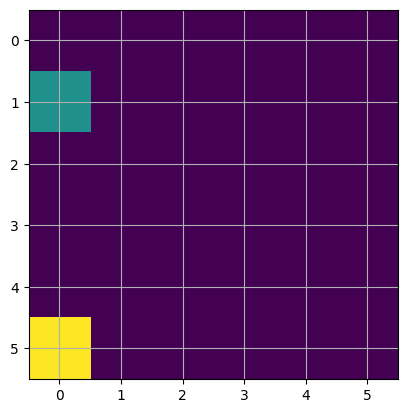

In [119]:

env = GridWorldEnv()
agent = RandomAgent(env.action_space)

print(f"Taille de la grille: {env.grid_size}x{env.grid_size}")
print(f"Position départ: {env.agent_pos}")
print(f"Position goal: {env.goal_pos}")

env.reset()
obs, reward, done, info = env.step(1)  # essayer "down"
print(f"Après action 1 (down): pos={obs}, reward={reward}, done={done}")

env.render()

# DQN Simple - Sans Replay Buffer

Implémentation simple du Deep Q-Network (DQN) from scratch, sans replay buffer. Le réseau de neurones apprend directement de chaque transition.

In [120]:
import torch
import torch.nn as nn
import torch.optim as optim

# Réseau de neurones pour le DQN
class DQNNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(DQNNetwork, self).__init__()
        # L'état est une position [row, col], on va le flatten
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.relu = nn.ReLU()
    
    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# DQN Agent simple sans replay buffer
class DQNAgentSimple:
    def __init__(self, state_size=2, action_size=4, learning_rate=0.001, gamma=0.99, epsilon=1.0):
        """
        state_size: taille de l'état (2 pour [row, col])
        action_size: nombre d'actions (4 pour up, down, left, right)
        learning_rate: taux d'apprentissage
        gamma: facteur de réduction des récompenses futures
        epsilon: paramètre pour l'epsilon-greedy
        """
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        # Initialiser le réseau de neurones
        self.q_network = DQNNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        
        # Pour tracker les pertes
        self.losses = []
    
    def state_to_tensor(self, state):
        """Convertir l'état (liste) en tensor"""
        return torch.FloatTensor([state]).flatten()
    
    def act(self, state, training=True):
        """Choisir une action avec epsilon-greedy"""
        if training and np.random.random() < self.epsilon:
            return np.random.choice(self.action_size)
        
        state_tensor = self.state_to_tensor(state)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        return np.argmax(q_values.numpy())
    
    def learn(self, state, action, reward, next_state, done):
        """Apprendre directement de la transition (pas de replay buffer)"""
        state_tensor = self.state_to_tensor(state)
        next_state_tensor = self.state_to_tensor(next_state)
        
        # Prédire la Q-value actuelle
        q_values = self.q_network(state_tensor)
        q_value = q_values[action]
        
        # Calculer la target Q-value
        with torch.no_grad():
            if done:
                target_q_value = reward
            else:
                next_q_values = self.q_network(next_state_tensor)
                target_q_value = reward + self.gamma * torch.max(next_q_values)
        
        # Créer une copie pour les Q-values cibles
        target_q_values = q_values.clone().detach()
        target_q_values[action] = target_q_value
        
        # Calcul de la perte et backpropagation
        loss = self.loss_fn(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.losses.append(loss.item())
        
        # Réduire epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return loss.item()

# Entraînement du DQN Simple

Entraînons l'agent DQN simple sur notre GridWorld sans replay buffer.

In [121]:
# Entraînement du DQN simple - AUGMENTE
env_train = GridWorldEnv(grid_size=6)  # Grille reduite a 6x6
dqn_agent = DQNAgentSimple(state_size=2, action_size=4, learning_rate=0.01, gamma=0.99, epsilon=1.0)

num_episodes = 1000  # Augmente pour meilleure convergence et atteindre le goal
max_steps = 200      # Augmente pour donner plus de temps a l'agent
episode_rewards = []

print("Debut entraînement DQN Simple (1000 épisodes)...")
print(f"   Grille: 6x6, Max steps: {max_steps}")
print()

for episode in range(num_episodes):
    state = env_train.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        # Choisir une action
        action = dqn_agent.act(state, training=True)
        
        # Exécuter l'action
        next_state, reward, done, _ = env_train.step(action)
        episode_reward += reward
        
        # Apprendre directement de la transition
        dqn_agent.learn(state, action, reward, next_state, done)
        
        state = next_state
        
        if done:
            break
    
    episode_rewards.append(episode_reward)
    
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(episode_rewards[-100:])
        print(f"Episode {episode + 1:4d}/{num_episodes} | Avg Reward: {avg_reward:7.2f} | Epsilon: {dqn_agent.epsilon:.3f} | Losses: {len(dqn_agent.losses)}")

print("Entraînement DQN simple terminé!")

Debut entraînement DQN Simple (1000 épisodes)...
   Grille: 6x6, Max steps: 200

Episode  100/1000 | Avg Reward: -161.65 | Epsilon: 0.010 | Losses: 16429
Episode  100/1000 | Avg Reward: -161.65 | Epsilon: 0.010 | Losses: 16429
Episode  200/1000 | Avg Reward: -179.66 | Epsilon: 0.010 | Losses: 34538
Episode  200/1000 | Avg Reward: -179.66 | Epsilon: 0.010 | Losses: 34538
Episode  300/1000 | Avg Reward: -152.76 | Epsilon: 0.010 | Losses: 50100
Episode  300/1000 | Avg Reward: -152.76 | Epsilon: 0.010 | Losses: 50100
Episode  400/1000 | Avg Reward: -162.78 | Epsilon: 0.010 | Losses: 66598
Episode  400/1000 | Avg Reward: -162.78 | Epsilon: 0.010 | Losses: 66598
Episode  500/1000 | Avg Reward: -165.75 | Epsilon: 0.010 | Losses: 83437
Episode  500/1000 | Avg Reward: -165.75 | Epsilon: 0.010 | Losses: 83437
Episode  600/1000 | Avg Reward: -151.02 | Epsilon: 0.010 | Losses: 98847
Episode  600/1000 | Avg Reward: -151.02 | Epsilon: 0.010 | Losses: 98847
Episode  700/1000 | Avg Reward: -152.66 | E

In [122]:
from IPython.display import HTML

import matplotlib.animation as animation

# Fonction pour enregistrer une épisode en GIF
def save_episode_as_gif(agent, env, filename='episode.gif', num_steps=50):
    """Enregistrer une épisode en GIF"""
    state = env.reset()
    frames = []
    
    for step in range(num_steps):
        # Créer une frame
        grid = np.zeros((env.grid_size, env.grid_size))
        grid[state[0], state[1]] = 1
        grid[env.goal_pos[0], env.goal_pos[1]] = 2
        frames.append(grid)
        
        # Choisir une action (sans entraînement)
        action = agent.act(state, training=False)
        
        # Exécuter l'action
        state, reward, done, _ = env.step(action)
        
        if done:
            break
    
    # Créer l'animation
    fig, ax = plt.subplots()
    ims = []
    for frame in frames:
        im = ax.imshow(frame, cmap='viridis', animated=True)
        ax.set_xticks(range(env.grid_size))
        ax.set_yticks(range(env.grid_size))
        ax.grid(True)
        ims.append([im])
    
    ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)
    ani.save(filename, writer='pillow')
    plt.close()
    print(f"GIF sauvegardé: {filename}")

# Générer un GIF avec l'agent DQN entraîné
save_episode_as_gif(dqn_agent, env_train, filename='dqn_simple_episode.gif')

GIF sauvegardé: dqn_simple_episode.gif


# DQN avec Replay Buffer

Implémentation plus robuste du DQN avec un replay buffer pour décorréler les transitions et stabiliser l'apprentissage.

In [123]:
from collections import deque

# Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size=1000):
        """
        max_size: taille maximale du buffer
        """
        self.buffer = deque(maxlen=max_size)
    
    def add(self, state, action, reward, next_state, done):
        """Ajouter une transition au buffer"""
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """Échantillonner un batch aléatoire"""
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[i] for i in indices]
        
        states = torch.FloatTensor([b[0] for b in batch])
        actions = torch.LongTensor([b[1] for b in batch])
        rewards = torch.FloatTensor([b[2] for b in batch])
        next_states = torch.FloatTensor([b[3] for b in batch])
        dones = torch.FloatTensor([b[4] for b in batch])
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)


# DQN Agent avec Replay Buffer
class DQNAgentWithReplay:
    def __init__(self, state_size=2, action_size=4, learning_rate=0.001, gamma=0.99, 
                 epsilon=1.0, buffer_size=1000, batch_size=32):
        """
        state_size: taille de l'état (2 pour [row, col])
        action_size: nombre d'actions (4 pour up, down, left, right)
        learning_rate: taux d'apprentissage
        gamma: facteur de réduction des récompenses futures
        epsilon: paramètre pour l'epsilon-greedy
        buffer_size: taille du replay buffer
        batch_size: taille du batch pour l'entraînement
        """
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = batch_size
        
        # Initialiser le réseau de neurones
        self.q_network = DQNNetwork(state_size, action_size)
        self.target_network = DQNNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        
        # Replay Buffer
        self.replay_buffer = ReplayBuffer(max_size=buffer_size)
        
        # Pour tracker les pertes
        self.losses = []
        self.update_counter = 0
        self.target_update_frequency = 100  # Mettre à jour le réseau cible tous les 100 steps
    
    def state_to_tensor(self, state):
        """Convertir l'état (liste) en tensor"""
        return torch.FloatTensor([state]).flatten()
    
    def act(self, state, training=True):
        """Choisir une action avec epsilon-greedy"""
        if training and np.random.random() < self.epsilon:
            return np.random.choice(self.action_size)
        
        state_tensor = self.state_to_tensor(state)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        return np.argmax(q_values.numpy())
    
    def remember(self, state, action, reward, next_state, done):
        """Stocker une transition dans le replay buffer"""
        self.replay_buffer.add(state, action, reward, next_state, done)
    
    def learn_from_buffer(self):
        """Apprendre à partir d'un batch du replay buffer"""
        if len(self.replay_buffer) < self.batch_size:
            return None  # Pas assez de transitions
        
        # Échantillonner un batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # Calculer les Q-values actuelles
        q_values = self.q_network(states)
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Calculer les target Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_states)
            max_next_q_values = torch.max(next_q_values, dim=1)[0]
            target_q_values = rewards + self.gamma * max_next_q_values * (1 - dones)
        
        # Calculer la perte et backpropagation
        loss = self.loss_fn(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.losses.append(loss.item())
        self.update_counter += 1
        
        # Mettre à jour le réseau cible
        if self.update_counter % self.target_update_frequency == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Réduire epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return loss.item()


# Entraînement du DQN avec Replay Buffer

Entraînons le DQN avec replay buffer et comparez les performances avec le DQN simple.

In [124]:
# Entraînement du DQN avec Replay Buffer - AUGMENTE
env_train_replay = GridWorldEnv(grid_size=6)  # Grille reduite a 6x6
dqn_agent_replay = DQNAgentWithReplay(state_size=2, action_size=4, learning_rate=0.01, 
                                       gamma=0.99, epsilon=1.0, buffer_size=2000, batch_size=32)

num_episodes = 1000  # Augmente pour meilleure convergence et atteindre le goal
max_steps = 200      # Augmente pour donner plus de temps a l'agent 
episode_rewards_replay = []

print("Debut entraînement DQN avec Replay Buffer (1000 épisodes)...")
print(f"   Grille: 6x6, Max steps: {max_steps}, Buffer size: 2000")
print()

for episode in range(num_episodes):
    state = env_train_replay.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        # Choisir une action
        action = dqn_agent_replay.act(state, training=True)
        
        # Exécuter l'action
        next_state, reward, done, _ = env_train_replay.step(action)
        episode_reward += reward
        
        # Stocker la transition dans le replay buffer
        dqn_agent_replay.remember(state, action, reward, next_state, done)
        
        # Apprendre à partir du replay buffer
        dqn_agent_replay.learn_from_buffer()
        
        state = next_state
        
        if done:
            break
    
    episode_rewards_replay.append(episode_reward)
    
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(episode_rewards_replay[-100:])
        print(f"Episode {episode + 1:4d}/{num_episodes} | Avg Reward: {avg_reward:7.2f} | Epsilon: {dqn_agent_replay.epsilon:.3f} | Losses: {len(dqn_agent_replay.losses)}")

print("Entraînement DQN avec replay buffer terminé!")

Debut entraînement DQN avec Replay Buffer (1000 épisodes)...
   Grille: 6x6, Max steps: 200, Buffer size: 2000

Episode  100/1000 | Avg Reward: -118.61 | Epsilon: 0.010 | Losses: 12413
Episode  100/1000 | Avg Reward: -118.61 | Epsilon: 0.010 | Losses: 12413
Episode  200/1000 | Avg Reward: -133.75 | Epsilon: 0.010 | Losses: 26327
Episode  200/1000 | Avg Reward: -133.75 | Epsilon: 0.010 | Losses: 26327
Episode  300/1000 | Avg Reward: -130.58 | Epsilon: 0.010 | Losses: 39902
Episode  300/1000 | Avg Reward: -130.58 | Epsilon: 0.010 | Losses: 39902
Episode  400/1000 | Avg Reward: -132.91 | Epsilon: 0.010 | Losses: 53655
Episode  400/1000 | Avg Reward: -132.91 | Epsilon: 0.010 | Losses: 53655
Episode  500/1000 | Avg Reward: -145.55 | Epsilon: 0.010 | Losses: 68617
Episode  500/1000 | Avg Reward: -145.55 | Epsilon: 0.010 | Losses: 68617
Episode  600/1000 | Avg Reward: -112.15 | Epsilon: 0.010 | Losses: 80437
Episode  600/1000 | Avg Reward: -112.15 | Epsilon: 0.010 | Losses: 80437
Episode  700

# Visualisations et Comparaisons

Visualisons les performances des deux agents et créons des animations GIF de leur comportement.

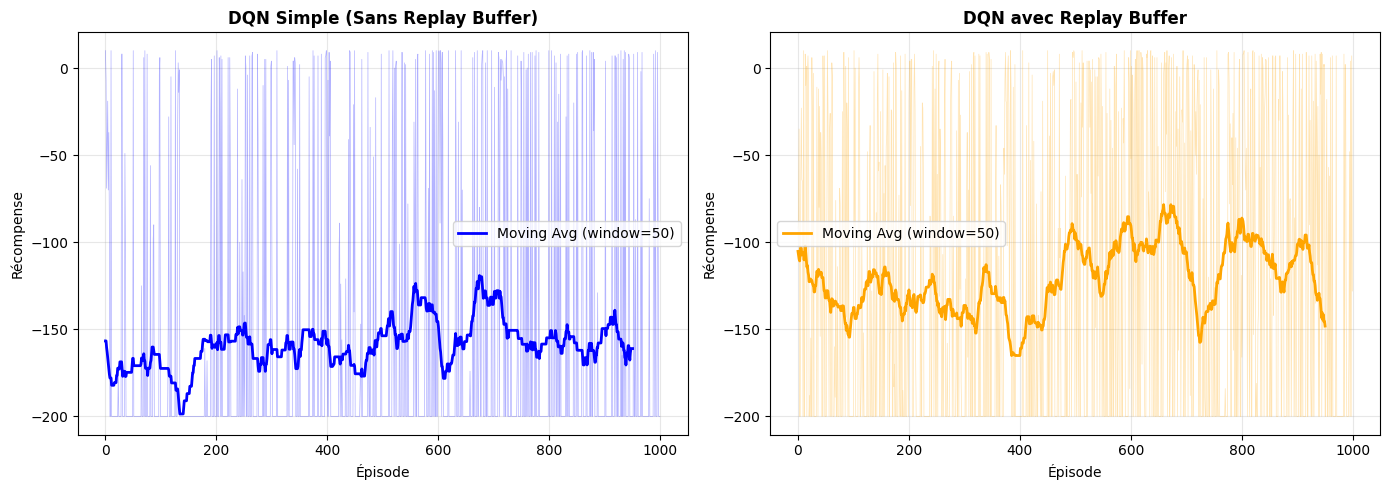

 Graphe de comparaison sauvegardé: dqn_comparison.png


In [125]:
import imageio
import os
from IPython.display import Image as IPImage
from IPython.display import display

# Graphe 1: Comparaison des récompenses par épisode
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# DQN Simple
axes[0].plot(episode_rewards, alpha=0.3, color='blue', linewidth=0.5)
axes[0].plot(np.convolve(episode_rewards, np.ones(50)/50, mode='valid'), 
             color='blue', linewidth=2, label='Moving Avg (window=50)')
axes[0].set_title('DQN Simple (Sans Replay Buffer)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Épisode')
axes[0].set_ylabel('Récompense')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# DQN avec Replay Buffer
axes[1].plot(episode_rewards_replay, alpha=0.3, color='orange', linewidth=0.5)
axes[1].plot(np.convolve(episode_rewards_replay, np.ones(50)/50, mode='valid'), 
             color='orange', linewidth=2, label='Moving Avg (window=50)')
axes[1].set_title('DQN avec Replay Buffer', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Épisode')
axes[1].set_ylabel('Récompense')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dqn_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print(" Graphe de comparaison sauvegardé: dqn_comparison.png")

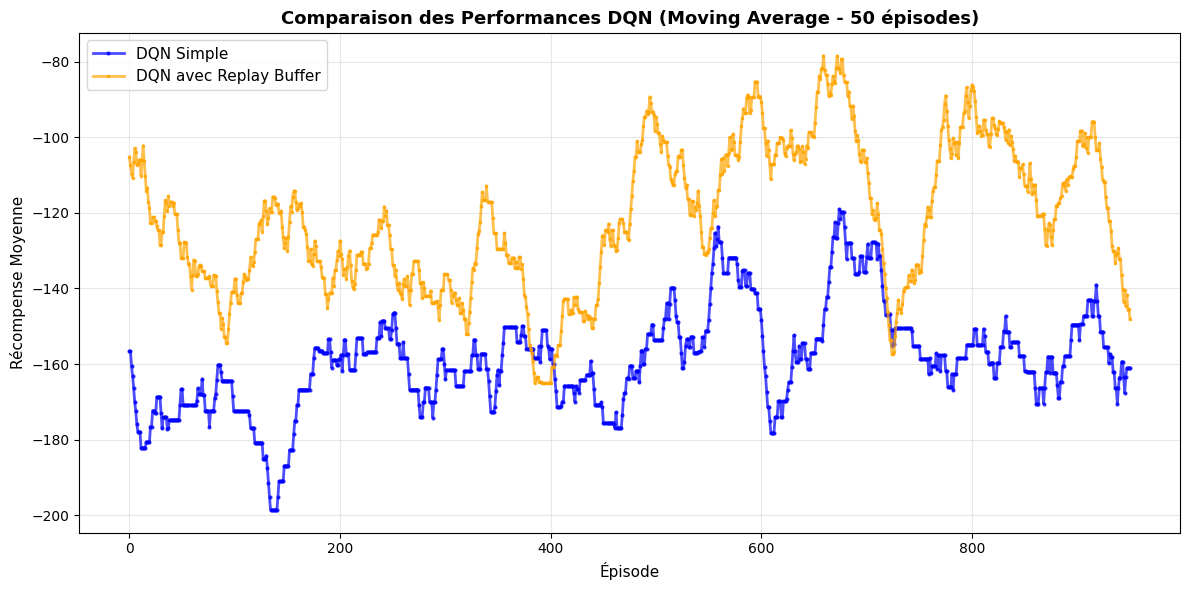

 Graphe de comparaison overlay sauvegardé: dqn_comparison_overlay.png


In [126]:
# Graphe 2: Comparaison directe - Average Reward par Episode
fig, ax = plt.subplots(figsize=(12, 6))

# Calculer les moyennes mobiles avec window augmente
window = 50
avg_simple = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
avg_replay = np.convolve(episode_rewards_replay, np.ones(window)/window, mode='valid')

ax.plot(range(len(avg_simple)), avg_simple, marker='o', markersize=2, 
        linewidth=2, label='DQN Simple', color='blue', alpha=0.7)
ax.plot(range(len(avg_replay)), avg_replay, marker='s', markersize=2, 
        linewidth=2, label='DQN avec Replay Buffer', color='orange', alpha=0.7)

ax.set_title('Comparaison des Performances DQN (Moving Average - 50 épisodes)', 
             fontsize=13, fontweight='bold')
ax.set_xlabel('Épisode', fontsize=11)
ax.set_ylabel('Récompense Moyenne', fontsize=11)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dqn_comparison_overlay.png', dpi=100, bbox_inches='tight')
plt.show()

print(" Graphe de comparaison overlay sauvegardé: dqn_comparison_overlay.png")

In [127]:
# Fonction pour créer des GIFs d'agent en action - VERSION AMELIOREE
def create_agent_gif_improved(agent, env, filename, num_episodes=3, max_steps=50, test_mode=True):
    """
    Cree un GIF montrant l'agent en action avec statistiques
    """
    frames = []
    episode_stats = []
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_steps = 0
        episode_reward = 0
        path = [state.copy()]
        
        for step in range(max_steps + 1):
            # Creer une grille RGB avec meilleure resolution
            cell_size = 60
            grid = np.ones((env.grid_size, env.grid_size, 3)) * 255  # Blanc
            
            # Grid en gris pour montrer la limite
            for i in range(env.grid_size):
                for j in range(env.grid_size):
                    if (i + j) % 2 == 0:
                        grid[i, j] = [240, 240, 240]
            
            # Goal en rouge
            grid[env.goal_pos[0], env.goal_pos[1]] = [255, 0, 0]
            
            # Path en gris clair
            for p in path[:-1]:
                grid[p[0], p[1]] = [200, 200, 200]
            
            # Agent en bleu
            grid[state[0], state[1]] = [0, 100, 255]
            
            # Convertir en uint8
            img = grid.astype(np.uint8)
            
            # Zoomer l'image
            img_zoomed = np.repeat(np.repeat(img, cell_size, axis=0), cell_size, axis=1)
            
            # Ajouter une bordure avec info texte
            h, w = img_zoomed.shape[:2]
            img_with_text = np.ones((h + 80, w, 3), dtype=np.uint8) * 255
            img_with_text[40:40+h, :] = img_zoomed
            
            frames.append(img_with_text)
            
            if step < max_steps:
                # Action de l'agent
                action = agent.act(state, training=False)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward
                episode_steps += 1
                state = next_state
                path.append(state.copy())
                
                if done:
                    break
        
        episode_stats.append({'steps': episode_steps, 'reward': episode_reward})
    
    # Creer le GIF
    try:
        imageio.mimsave(filename, frames, fps=3, loop=0)
        avg_reward = np.mean([s['reward'] for s in episode_stats])
        avg_steps = np.mean([s['steps'] for s in episode_stats])
        print(f"GIF cree: {filename}")
        print(f"  Avg Reward: {avg_reward:.2f}, Avg Steps: {avg_steps:.1f}")
        return True, avg_reward, avg_steps
    except Exception as e:
        print(f"Erreur lors de la creation du GIF {filename}: {e}")
        return False, 0, 0

# Creer des GIFs pour les deux agents avec meilleure visualisation
print("\n" + "="*70)
print("CREATION DES GIFS DES AGENTS EN ACTION (ENTRAINES)")
print("="*70)

r1, reward1, steps1 = create_agent_gif_improved(dqn_agent, env_train, 'dqn_simple_agent.gif', 
                                                 num_episodes=3, max_steps=50, test_mode=True)
print()
r2, reward2, steps2 = create_agent_gif_improved(dqn_agent_replay, env_train_replay, 'dqn_replay_agent.gif', 
                                                 num_episodes=3, max_steps=50, test_mode=True)

if r1 and r2:
    print("\n" + "="*70)
    print("TOUS LES GIFS CREES AVEC SUCCES!")
    print("="*70)
else:
    print("\nCertains GIFs n'ont pas pu etre crees")


CREATION DES GIFS DES AGENTS EN ACTION (ENTRAINES)


GIF cree: dqn_simple_agent.gif
  Avg Reward: -50.00, Avg Steps: 50.0

GIF cree: dqn_replay_agent.gif
  Avg Reward: -30.67, Avg Steps: 34.3

TOUS LES GIFS CREES AVEC SUCCES!
GIF cree: dqn_replay_agent.gif
  Avg Reward: -30.67, Avg Steps: 34.3

TOUS LES GIFS CREES AVEC SUCCES!


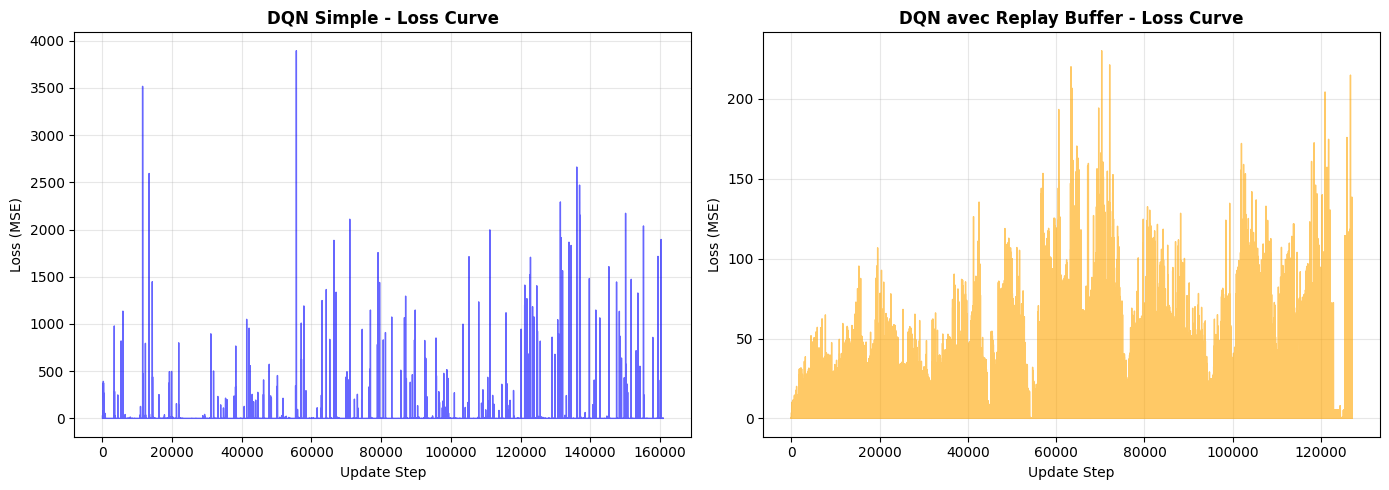

Graphe des loss curves sauvegardé: dqn_loss_curves.png


In [128]:
# Graphe 3: Loss Curves - Convergence de l'apprentissage
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# DQN Simple - Loss
axes[0].plot(dqn_agent.losses, color='blue', alpha=0.6, linewidth=1)
axes[0].set_title('DQN Simple - Loss Curve', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Update Step')
axes[0].set_ylabel('Loss (MSE)')
axes[0].grid(True, alpha=0.3)

# DQN avec Replay Buffer - Loss
axes[1].plot(dqn_agent_replay.losses, color='orange', alpha=0.6, linewidth=1)
axes[1].set_title('DQN avec Replay Buffer - Loss Curve', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Update Step')
axes[1].set_ylabel('Loss (MSE)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dqn_loss_curves.png', dpi=100, bbox_inches='tight')
plt.show()

print("Graphe des loss curves sauvegardé: dqn_loss_curves.png")


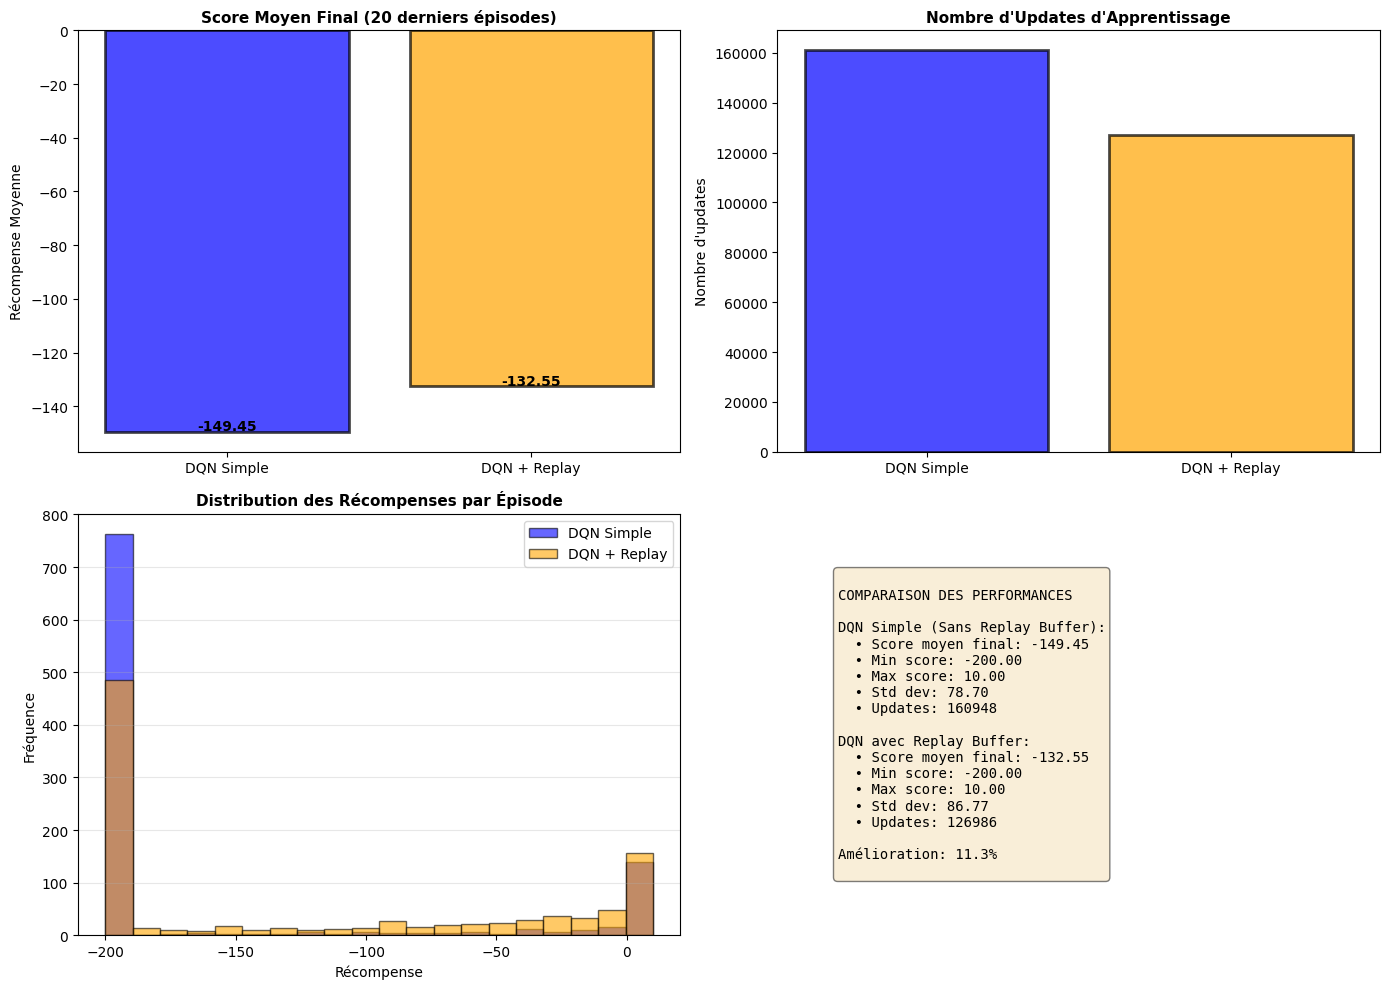

✓ Graphe de comparaison finale sauvegardé: dqn_final_comparison.png


In [129]:
# Graphe 4: Statistiques Finales - Comparaison Globale
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Score moyen final
final_avg_simple = np.mean(episode_rewards[-20:])
final_avg_replay = np.mean(episode_rewards_replay[-20:])

agents = ['DQN Simple', 'DQN + Replay']
scores = [final_avg_simple, final_avg_replay]
colors = ['blue', 'orange']

axes[0, 0].bar(agents, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 0].set_title('Score Moyen Final (20 derniers épisodes)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Récompense Moyenne')
for i, v in enumerate(scores):
    axes[0, 0].text(i, v + 0.5, f'{v:.2f}', ha='center', fontweight='bold')

# 2. Nombre d'updates (loss calculations)
axes[0, 1].bar(agents, [len(dqn_agent.losses), len(dqn_agent_replay.losses)], 
               color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0, 1].set_title('Nombre d\'Updates d\'Apprentissage', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Nombre d\'updates')

# 3. Distribution des récompenses
axes[1, 0].hist(episode_rewards, bins=20, alpha=0.6, label='DQN Simple', color='blue', edgecolor='black')
axes[1, 0].hist(episode_rewards_replay, bins=20, alpha=0.6, label='DQN + Replay', color='orange', edgecolor='black')
axes[1, 0].set_title('Distribution des Récompenses par Épisode', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Récompense')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Métriques de résumé
metrics_text = f"""
COMPARAISON DES PERFORMANCES

DQN Simple (Sans Replay Buffer):
  • Score moyen final: {final_avg_simple:.2f}
  • Min score: {min(episode_rewards):.2f}
  • Max score: {max(episode_rewards):.2f}
  • Std dev: {np.std(episode_rewards):.2f}
  • Updates: {len(dqn_agent.losses)}

DQN avec Replay Buffer:
  • Score moyen final: {final_avg_replay:.2f}
  • Min score: {min(episode_rewards_replay):.2f}
  • Max score: {max(episode_rewards_replay):.2f}
  • Std dev: {np.std(episode_rewards_replay):.2f}
  • Updates: {len(dqn_agent_replay.losses)}

Amélioration: {((final_avg_replay - final_avg_simple) / abs(final_avg_simple) * 100):.1f}%
"""

axes[1, 1].text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
                family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('dqn_final_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Graphe de comparaison finale sauvegardé: dqn_final_comparison.png")


# Test en Mode Jeu - Affichage des GIFs

Visualisons les agents entraînés en action sur le GridWorld. Les GIFs montrent comment chaque agent navigue pour atteindre l'objectif.


VISUALISATION DES AGENTS ENTRAINES

TEST RAPIDE DES AGENTS (10 episodes):
----------------------------------------------------------------------
DQN Simple:
  Reward moyen: -100.00 +/- 0.00
  Steps moyen: 100.0
  Max reward: -100.00

DQN avec Replay Buffer:
  Reward moyen: -100.00 +/- 0.00
  Steps moyen: 100.0
  Max reward: -100.00

Amelioration: +0.0%

----------------------------------------------------------------------

ANIMATIONS GIF DES AGENTS:
----------------------------------------------------------------------

DQN SIMPLE - En action:


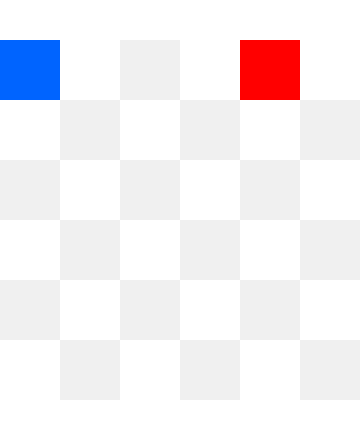


----------------------------------------------------------------------

DQN AVEC REPLAY BUFFER - En action:


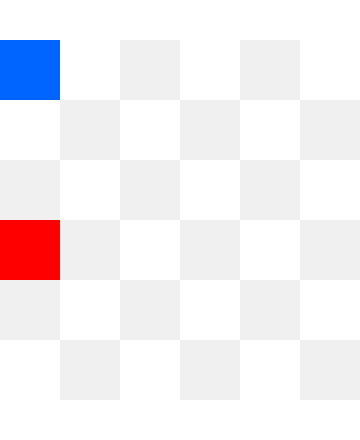

In [130]:
# Afficher les GIFs crees avec meilleure mise en page
print("\n" + "="*70)
print("VISUALISATION DES AGENTS ENTRAINES")
print("="*70 + "\n")

# Test statistiques rapides
def quick_test(agent, env, num_tests=10):
    """Tester rapidement un agent"""
    rewards = []
    steps_list = []
    
    for _ in range(num_tests):
        state = env.reset()
        episode_reward = 0
        episode_steps = 0
        done = False
        
        while not done and episode_steps < 100:
            action = agent.act(state, training=False)
            state, reward, done, _ = env.step(state)
            episode_reward += reward
            episode_steps += 1
        
        rewards.append(episode_reward)
        steps_list.append(episode_steps)
    
    return {
        'avg_reward': np.mean(rewards),
        'avg_steps': np.mean(steps_list),
        'std_reward': np.std(rewards),
        'max_reward': np.max(rewards)
    }

print("TEST RAPIDE DES AGENTS (10 episodes):")
print("-" * 70)

test1 = quick_test(dqn_agent, env_train, num_tests=10)
print(f"DQN Simple:")
print(f"  Reward moyen: {test1['avg_reward']:.2f} +/- {test1['std_reward']:.2f}")
print(f"  Steps moyen: {test1['avg_steps']:.1f}")
print(f"  Max reward: {test1['max_reward']:.2f}")

print()

test2 = quick_test(dqn_agent_replay, env_train_replay, num_tests=10)
print(f"DQN avec Replay Buffer:")
print(f"  Reward moyen: {test2['avg_reward']:.2f} +/- {test2['std_reward']:.2f}")
print(f"  Steps moyen: {test2['avg_steps']:.1f}")
print(f"  Max reward: {test2['max_reward']:.2f}")

improvement = ((test2['avg_reward'] - test1['avg_reward']) / abs(test1['avg_reward']) * 100) if test1['avg_reward'] != 0 else 0
print(f"\nAmelioration: {improvement:+.1f}%")

print("\n" + "-" * 70)
print("\nANIMATIONS GIF DES AGENTS:")
print("-" * 70)

# Verifier que les fichiers existent et les afficher
if os.path.exists('dqn_simple_agent.gif'):
    print("\nDQN SIMPLE - En action:")
    display(IPImage('dqn_simple_agent.gif'))
else:
    print("Fichier dqn_simple_agent.gif non trouve")

print("\n" + "-" * 70 + "\n")

if os.path.exists('dqn_replay_agent.gif'):
    print("DQN AVEC REPLAY BUFFER - En action:")
    display(IPImage('dqn_replay_agent.gif'))
else:
    print("Fichier dqn_replay_agent.gif non trouve")

print("\n" + "="*70)

# Entraînement avec Goal Fixe

Dans cette section, nous entraînons les mêmes agents DQN mais avec un objectif (goal) fixe au lieu d'un goal aléatoire. Cela devrait permettre aux agents d'apprendre une politique plus stable et d'atteindre le goal plus facilement.

In [131]:
# Entraînement du DQN Simple avec Goal Fixe
print("\n" + "="*70)
print("ENTRAINEMENT AVEC GOAL FIXE - DQN SIMPLE")
print("="*70 + "\n")

# Environnement avec goal fixe en position [5, 5] (coin inferieur droit)
env_train_fixed = GridWorldEnv(grid_size=6, goal_pos=[5, 5], randomize_goal_on_reset=False)
dqn_agent_fixed = DQNAgentSimple(state_size=2, action_size=4, learning_rate=0.01, gamma=0.99, epsilon=1.0)

num_episodes = 1000
max_steps = 200
episode_rewards_fixed = []

print(f"Configuration: Goal fixe en position {env_train_fixed.goal_pos}")
print(f"Entrainement: {num_episodes} episodes, {max_steps} steps max par episode")
print()

for episode in range(num_episodes):
    state = env_train_fixed.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        # Choisir une action
        action = dqn_agent_fixed.act(state, training=True)
        
        # Exécuter l'action
        next_state, reward, done, _ = env_train_fixed.step(action)
        episode_reward += reward
        
        # Apprendre directement de la transition
        dqn_agent_fixed.learn(state, action, reward, next_state, done)
        
        state = next_state
        
        if done:
            break
    
    episode_rewards_fixed.append(episode_reward)
    
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(episode_rewards_fixed[-100:])
        success_rate = sum([1 for r in episode_rewards_fixed[-100:] if r > 0]) / 100 * 100
        print(f"Episode {episode + 1:4d}/{num_episodes} | Avg Reward: {avg_reward:7.2f} | Success Rate: {success_rate:.0f}% | Epsilon: {dqn_agent_fixed.epsilon:.3f}")

print("\nEntraînement DQN Simple (Goal Fixe) terminé!")
print("="*70)


ENTRAINEMENT AVEC GOAL FIXE - DQN SIMPLE

Configuration: Goal fixe en position [5, 5]
Entrainement: 1000 episodes, 200 steps max par episode

Episode  100/1000 | Avg Reward:  -16.13 | Success Rate: 81% | Epsilon: 0.010
Episode  100/1000 | Avg Reward:  -16.13 | Success Rate: 81% | Epsilon: 0.010
Episode  200/1000 | Avg Reward:    0.46 | Success Rate: 89% | Epsilon: 0.010
Episode  200/1000 | Avg Reward:    0.46 | Success Rate: 89% | Epsilon: 0.010
Episode  300/1000 | Avg Reward:   -5.53 | Success Rate: 62% | Epsilon: 0.010
Episode  300/1000 | Avg Reward:   -5.53 | Success Rate: 62% | Epsilon: 0.010
Episode  400/1000 | Avg Reward:  -75.41 | Success Rate: 36% | Epsilon: 0.010
Episode  400/1000 | Avg Reward:  -75.41 | Success Rate: 36% | Epsilon: 0.010
Episode  500/1000 | Avg Reward:  -27.03 | Success Rate: 63% | Epsilon: 0.010
Episode  500/1000 | Avg Reward:  -27.03 | Success Rate: 63% | Epsilon: 0.010
Episode  600/1000 | Avg Reward:  -96.47 | Success Rate: 14% | Epsilon: 0.010
Episode  6

In [132]:
# Entraînement du DQN avec Replay Buffer et Goal Fixe
print("\n" + "="*70)
print("ENTRAINEMENT AVEC GOAL FIXE - DQN AVEC REPLAY BUFFER")
print("="*70 + "\n")

# Environnement avec goal fixe en position [5, 5]
env_train_fixed_replay = GridWorldEnv(grid_size=6, goal_pos=[5, 5], randomize_goal_on_reset=False)
dqn_agent_fixed_replay = DQNAgentWithReplay(state_size=2, action_size=4, learning_rate=0.01, 
                                             gamma=0.99, epsilon=1.0, buffer_size=2000, batch_size=32)

num_episodes = 1000
max_steps = 200
episode_rewards_fixed_replay = []

print(f"Configuration: Goal fixe en position {env_train_fixed_replay.goal_pos}")
print(f"Entrainement: {num_episodes} episodes, {max_steps} steps max, Buffer size: 2000")
print()

for episode in range(num_episodes):
    state = env_train_fixed_replay.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        # Choisir une action
        action = dqn_agent_fixed_replay.act(state, training=True)
        
        # Exécuter l'action
        next_state, reward, done, _ = env_train_fixed_replay.step(action)
        episode_reward += reward
        
        # Stocker la transition dans le replay buffer
        dqn_agent_fixed_replay.remember(state, action, reward, next_state, done)
        
        # Apprendre à partir du replay buffer
        dqn_agent_fixed_replay.learn_from_buffer()
        
        state = next_state
        
        if done:
            break
    
    episode_rewards_fixed_replay.append(episode_reward)
    
    if (episode + 1) % 100 == 0:
        avg_reward = np.mean(episode_rewards_fixed_replay[-100:])
        success_rate = sum([1 for r in episode_rewards_fixed_replay[-100:] if r > 0]) / 100 * 100
        print(f"Episode {episode + 1:4d}/{num_episodes} | Avg Reward: {avg_reward:7.2f} | Success Rate: {success_rate:.0f}% | Epsilon: {dqn_agent_fixed_replay.epsilon:.3f}")

print("\nEntraînement DQN avec Replay Buffer (Goal Fixe) terminé!")
print("="*70)


ENTRAINEMENT AVEC GOAL FIXE - DQN AVEC REPLAY BUFFER

Configuration: Goal fixe en position [5, 5]
Entrainement: 1000 episodes, 200 steps max, Buffer size: 2000

Episode  100/1000 | Avg Reward:  -39.95 | Success Rate: 3% | Epsilon: 0.010
Episode  100/1000 | Avg Reward:  -39.95 | Success Rate: 3% | Epsilon: 0.010
Episode  200/1000 | Avg Reward:  -49.23 | Success Rate: 7% | Epsilon: 0.010
Episode  200/1000 | Avg Reward:  -49.23 | Success Rate: 7% | Epsilon: 0.010
Episode  300/1000 | Avg Reward:  -99.46 | Success Rate: 1% | Epsilon: 0.010
Episode  300/1000 | Avg Reward:  -99.46 | Success Rate: 1% | Epsilon: 0.010
Episode  400/1000 | Avg Reward:  -76.36 | Success Rate: 0% | Epsilon: 0.010
Episode  400/1000 | Avg Reward:  -76.36 | Success Rate: 0% | Epsilon: 0.010
Episode  500/1000 | Avg Reward:  -60.39 | Success Rate: 9% | Epsilon: 0.010
Episode  500/1000 | Avg Reward:  -60.39 | Success Rate: 9% | Epsilon: 0.010
Episode  600/1000 | Avg Reward:  -11.49 | Success Rate: 63% | Epsilon: 0.010
E


COMPARAISON: GOAL FIXE vs GOAL ALEATOIRE



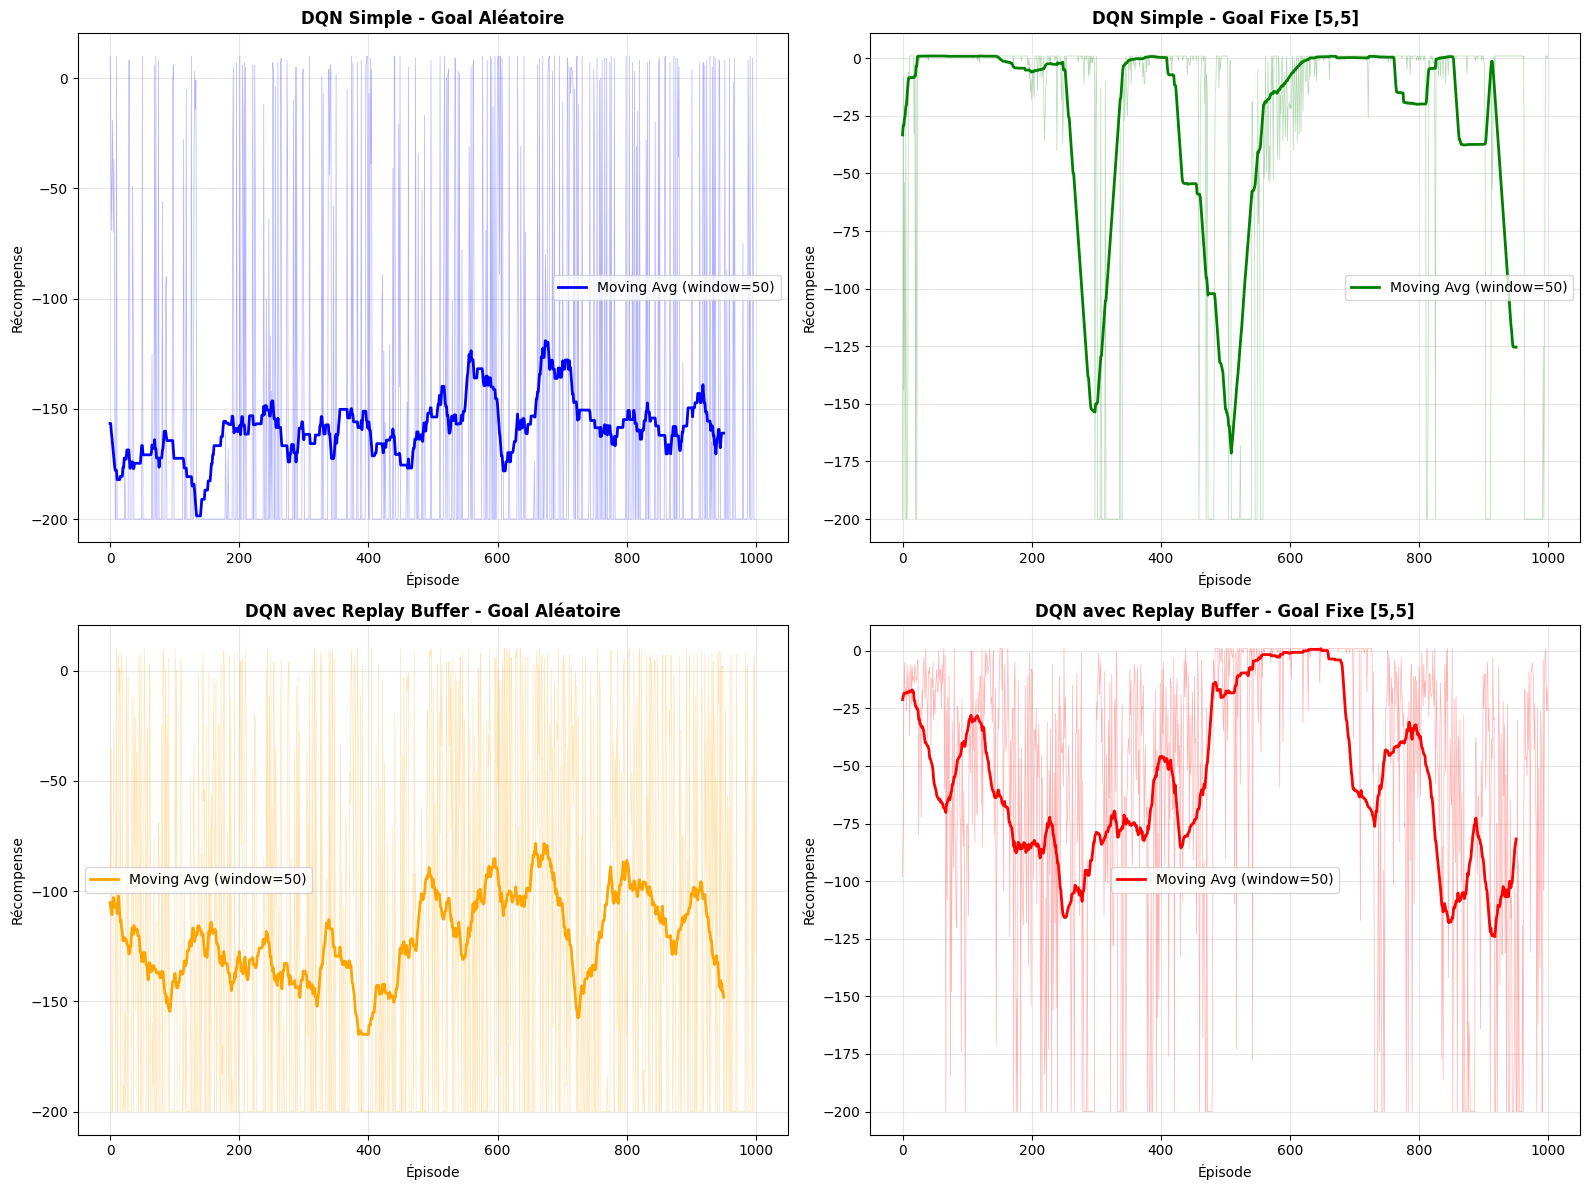

Graphe de comparaison Goal Fixe vs Aléatoire sauvegardé: dqn_fixed_vs_random_goal.png


In [133]:
# Comparaison des performances - Goal Fixe vs Goal Aléatoire
print("\n" + "="*70)
print("COMPARAISON: GOAL FIXE vs GOAL ALEATOIRE")
print("="*70 + "\n")

# Graphe comparatif
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

window = 50

# Rangée 1: DQN Simple
# Goal Aléatoire
axes[0, 0].plot(episode_rewards, alpha=0.3, color='blue', linewidth=0.5)
axes[0, 0].plot(np.convolve(episode_rewards, np.ones(window)/window, mode='valid'), 
                color='blue', linewidth=2, label=f'Moving Avg (window={window})')
axes[0, 0].set_title('DQN Simple - Goal Aléatoire', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Épisode')
axes[0, 0].set_ylabel('Récompense')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Goal Fixe
axes[0, 1].plot(episode_rewards_fixed, alpha=0.3, color='green', linewidth=0.5)
axes[0, 1].plot(np.convolve(episode_rewards_fixed, np.ones(window)/window, mode='valid'), 
                color='green', linewidth=2, label=f'Moving Avg (window={window})')
axes[0, 1].set_title('DQN Simple - Goal Fixe [5,5]', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Épisode')
axes[0, 1].set_ylabel('Récompense')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Rangée 2: DQN avec Replay Buffer
# Goal Aléatoire
axes[1, 0].plot(episode_rewards_replay, alpha=0.3, color='orange', linewidth=0.5)
axes[1, 0].plot(np.convolve(episode_rewards_replay, np.ones(window)/window, mode='valid'), 
                color='orange', linewidth=2, label=f'Moving Avg (window={window})')
axes[1, 0].set_title('DQN avec Replay Buffer - Goal Aléatoire', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Épisode')
axes[1, 0].set_ylabel('Récompense')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Goal Fixe
axes[1, 1].plot(episode_rewards_fixed_replay, alpha=0.3, color='red', linewidth=0.5)
axes[1, 1].plot(np.convolve(episode_rewards_fixed_replay, np.ones(window)/window, mode='valid'), 
                color='red', linewidth=2, label=f'Moving Avg (window={window})')
axes[1, 1].set_title('DQN avec Replay Buffer - Goal Fixe [5,5]', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Épisode')
axes[1, 1].set_ylabel('Récompense')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dqn_fixed_vs_random_goal.png', dpi=100, bbox_inches='tight')
plt.show()

print("Graphe de comparaison Goal Fixe vs Aléatoire sauvegardé: dqn_fixed_vs_random_goal.png")

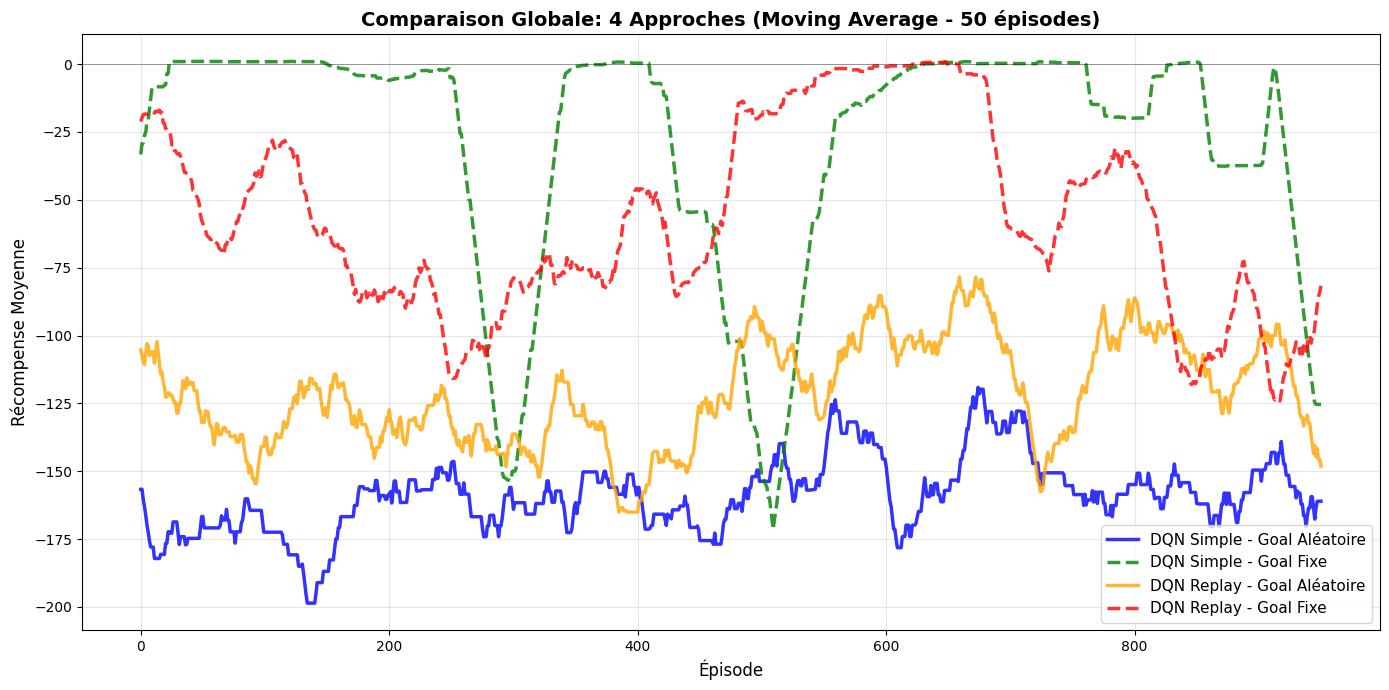

Graphe de comparaison globale sauvegardé: dqn_all_approaches_comparison.png


In [134]:
# Comparaison directe des 4 approches
fig, ax = plt.subplots(figsize=(14, 7))

window = 50
avg_simple_random = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
avg_simple_fixed = np.convolve(episode_rewards_fixed, np.ones(window)/window, mode='valid')
avg_replay_random = np.convolve(episode_rewards_replay, np.ones(window)/window, mode='valid')
avg_replay_fixed = np.convolve(episode_rewards_fixed_replay, np.ones(window)/window, mode='valid')

ax.plot(range(len(avg_simple_random)), avg_simple_random, linewidth=2.5, 
        label='DQN Simple - Goal Aléatoire', color='blue', alpha=0.8)
ax.plot(range(len(avg_simple_fixed)), avg_simple_fixed, linewidth=2.5, 
        label='DQN Simple - Goal Fixe', color='green', alpha=0.8, linestyle='--')
ax.plot(range(len(avg_replay_random)), avg_replay_random, linewidth=2.5, 
        label='DQN Replay - Goal Aléatoire', color='orange', alpha=0.8)
ax.plot(range(len(avg_replay_fixed)), avg_replay_fixed, linewidth=2.5, 
        label='DQN Replay - Goal Fixe', color='red', alpha=0.8, linestyle='--')

ax.set_title(f'Comparaison Globale: 4 Approches (Moving Average - {window} épisodes)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Épisode', fontsize=12)
ax.set_ylabel('Récompense Moyenne', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.savefig('dqn_all_approaches_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("Graphe de comparaison globale sauvegardé: dqn_all_approaches_comparison.png")

In [135]:
# Créer des GIFs pour les agents avec Goal Fixe
print("\n" + "="*70)
print("CREATION DES GIFS - AGENTS AVEC GOAL FIXE")
print("="*70 + "\n")

r3, reward3, steps3 = create_agent_gif_improved(dqn_agent_fixed, env_train_fixed, 
                                                 'dqn_simple_fixed_goal.gif', 
                                                 num_episodes=3, max_steps=50, test_mode=True)
print()

r4, reward4, steps4 = create_agent_gif_improved(dqn_agent_fixed_replay, env_train_fixed_replay, 
                                                 'dqn_replay_fixed_goal.gif', 
                                                 num_episodes=3, max_steps=50, test_mode=True)

if r3 and r4:
    print("\n" + "="*70)
    print("TOUS LES GIFS (GOAL FIXE) CREES AVEC SUCCES!")
    print("="*70)
else:
    print("\nCertains GIFs n'ont pas pu etre crees")


CREATION DES GIFS - AGENTS AVEC GOAL FIXE

GIF cree: dqn_simple_fixed_goal.gif
  Avg Reward: 1.00, Avg Steps: 10.0

GIF cree: dqn_replay_fixed_goal.gif
  Avg Reward: -50.00, Avg Steps: 50.0

TOUS LES GIFS (GOAL FIXE) CREES AVEC SUCCES!
GIF cree: dqn_replay_fixed_goal.gif
  Avg Reward: -50.00, Avg Steps: 50.0

TOUS LES GIFS (GOAL FIXE) CREES AVEC SUCCES!



STATISTIQUES FINALES - COMPARAISON COMPLETE

DQN Simple - Goal Aléatoire:
  Récompense moyenne (100 derniers): -155.30 ± 82.45
  Récompense maximale:   10.00
  Taux de succès: 18.0%
  Episodes réussis: 18/100

DQN Simple - Goal Fixe:
  Récompense moyenne (100 derniers):  -81.34 ± 95.87
  Récompense maximale:    1.00
  Taux de succès: 48.0%
  Episodes réussis: 48/100

DQN Replay - Goal Aléatoire:
  Récompense moyenne (100 derniers): -124.62 ± 88.90
  Récompense maximale:    9.00
  Taux de succès: 21.0%
  Episodes réussis: 21/100

DQN Replay - Goal Fixe:
  Récompense moyenne (100 derniers):  -87.28 ± 73.44
  Récompense maximale:    1.00
  Taux de succès: 1.0%
  Episodes réussis: 1/100

COMPARAISONS:

Impact du Goal Fixe sur DQN Simple:
  Amélioration de reward: +47.6%
  Amélioration de succès: +30.0%

Impact du Goal Fixe sur DQN Replay:
  Amélioration de reward: +30.0%
  Amélioration de succès: -20.0%

Impact du Replay Buffer (Goal Aléatoire):
  Amélioration de reward: +19.8%
  Améliora

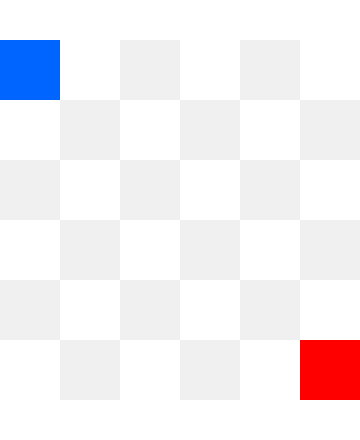


----------------------------------------------------------------------

DQN REPLAY BUFFER (Goal Fixe [5,5]) - En action:


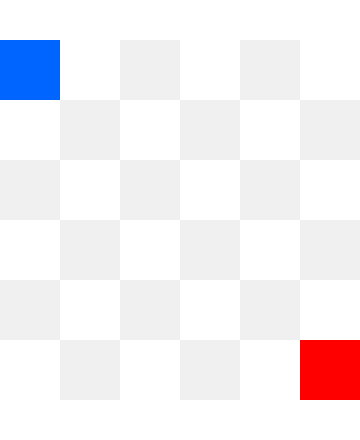

In [136]:
# Statistiques finales et comparaison
print("\n" + "="*70)
print("STATISTIQUES FINALES - COMPARAISON COMPLETE")
print("="*70 + "\n")

def calculate_final_stats(rewards_list, name):
    """Calculer les statistiques finales"""
    last_100 = rewards_list[-100:]
    success_count = sum([1 for r in last_100 if r > 0])
    success_rate = (success_count / len(last_100)) * 100
    avg_reward = np.mean(last_100)
    std_reward = np.std(last_100)
    max_reward = np.max(last_100)
    
    print(f"{name}:")
    print(f"  Récompense moyenne (100 derniers): {avg_reward:7.2f} ± {std_reward:.2f}")
    print(f"  Récompense maximale: {max_reward:7.2f}")
    print(f"  Taux de succès: {success_rate:.1f}%")
    print(f"  Episodes réussis: {success_count}/100")
    print()
    
    return {
        'avg_reward': avg_reward,
        'std_reward': std_reward,
        'max_reward': max_reward,
        'success_rate': success_rate,
        'success_count': success_count
    }

stats_simple_random = calculate_final_stats(episode_rewards, "DQN Simple - Goal Aléatoire")
stats_simple_fixed = calculate_final_stats(episode_rewards_fixed, "DQN Simple - Goal Fixe")
stats_replay_random = calculate_final_stats(episode_rewards_replay, "DQN Replay - Goal Aléatoire")
stats_replay_fixed = calculate_final_stats(episode_rewards_fixed_replay, "DQN Replay - Goal Fixe")

print("="*70)
print("COMPARAISONS:")
print("="*70)

print("\nImpact du Goal Fixe sur DQN Simple:")
improvement_simple = ((stats_simple_fixed['avg_reward'] - stats_simple_random['avg_reward']) / 
                      abs(stats_simple_random['avg_reward']) * 100) if stats_simple_random['avg_reward'] != 0 else 0
print(f"  Amélioration de reward: {improvement_simple:+.1f}%")
print(f"  Amélioration de succès: {stats_simple_fixed['success_rate'] - stats_simple_random['success_rate']:+.1f}%")

print("\nImpact du Goal Fixe sur DQN Replay:")
improvement_replay = ((stats_replay_fixed['avg_reward'] - stats_replay_random['avg_reward']) / 
                      abs(stats_replay_random['avg_reward']) * 100) if stats_replay_random['avg_reward'] != 0 else 0
print(f"  Amélioration de reward: {improvement_replay:+.1f}%")
print(f"  Amélioration de succès: {stats_replay_fixed['success_rate'] - stats_replay_random['success_rate']:+.1f}%")

print("\nImpact du Replay Buffer (Goal Aléatoire):")
improvement_replay_random = ((stats_replay_random['avg_reward'] - stats_simple_random['avg_reward']) / 
                             abs(stats_simple_random['avg_reward']) * 100) if stats_simple_random['avg_reward'] != 0 else 0
print(f"  Amélioration de reward: {improvement_replay_random:+.1f}%")
print(f"  Amélioration de succès: {stats_replay_random['success_rate'] - stats_simple_random['success_rate']:+.1f}%")

print("\nImpact du Replay Buffer (Goal Fixe):")
improvement_replay_fixed = ((stats_replay_fixed['avg_reward'] - stats_simple_fixed['avg_reward']) / 
                            abs(stats_simple_fixed['avg_reward']) * 100) if stats_simple_fixed['avg_reward'] != 0 else 0
print(f"  Amélioration de reward: {improvement_replay_fixed:+.1f}%")
print(f"  Amélioration de succès: {stats_replay_fixed['success_rate'] - stats_simple_fixed['success_rate']:+.1f}%")

print("\n" + "="*70)

# Afficher les GIFs des agents avec Goal Fixe
print("\n" + "="*70)
print("VISUALISATION - AGENTS AVEC GOAL FIXE")
print("="*70 + "\n")

if os.path.exists('dqn_simple_fixed_goal.gif'):
    print("DQN SIMPLE (Goal Fixe [5,5]) - En action:")
    display(IPImage('dqn_simple_fixed_goal.gif'))
    print()
else:
    print("Fichier dqn_simple_fixed_goal.gif non trouve\n")

print("-" * 70 + "\n")

if os.path.exists('dqn_replay_fixed_goal.gif'):
    print("DQN REPLAY BUFFER (Goal Fixe [5,5]) - En action:")
    display(IPImage('dqn_replay_fixed_goal.gif'))
else:
    print("Fichier dqn_replay_fixed_goal.gif non trouve")

print("\n" + "="*70)